In [ ]:
# Problem Statement:
 
# Build a machine learning model to predict whether the shipment will arrive on time or not. ( column ‘Reached.on.Time_Y.N’ from the attached data needs to be predicted )
 
# You can consider that shipment which would arrive late is a higher risk for business. So, predicting potentially delayed shipments would be a big win so that business can take necessary steps to mitigate the issues.
 
 
# Evaluation will be based on
 
# Missing value imputation method
# ML model built.
# Model fine tuning
# Results

In [3]:
# Importing all the required libraries for this model building


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [4]:
#. Loading the dataset and displying the first few rows and checking the datatypes of every columns.

data = pd.read_csv('D:\Sarabjeet Kour Data\Downloads\data (1) (1).csv')
print(data)
print()
print(data.info())

# Dropping the 'ID' column as it's not a feature
data = data.drop(columns=['ID'])


          ID Warehouse_block Mode_of_Shipment  Customer_care_calls  \
0          1               D           Flight                    4   
1          2               F           Flight                    4   
2          3               A           Flight                    2   
3          4               B           Flight                    3   
4          5               C           Flight                    2   
...      ...             ...              ...                  ...   
10994  10995               A             Ship                    4   
10995  10996               B             Ship                    4   
10996  10997               C             Ship                    5   
10997  10998               F             Ship                    5   
10998  10999               D             Ship                    2   

       Customer_rating  Cost_of_the_Product  Prior_purchases  \
0                    2                177.0                3   
1                    5         

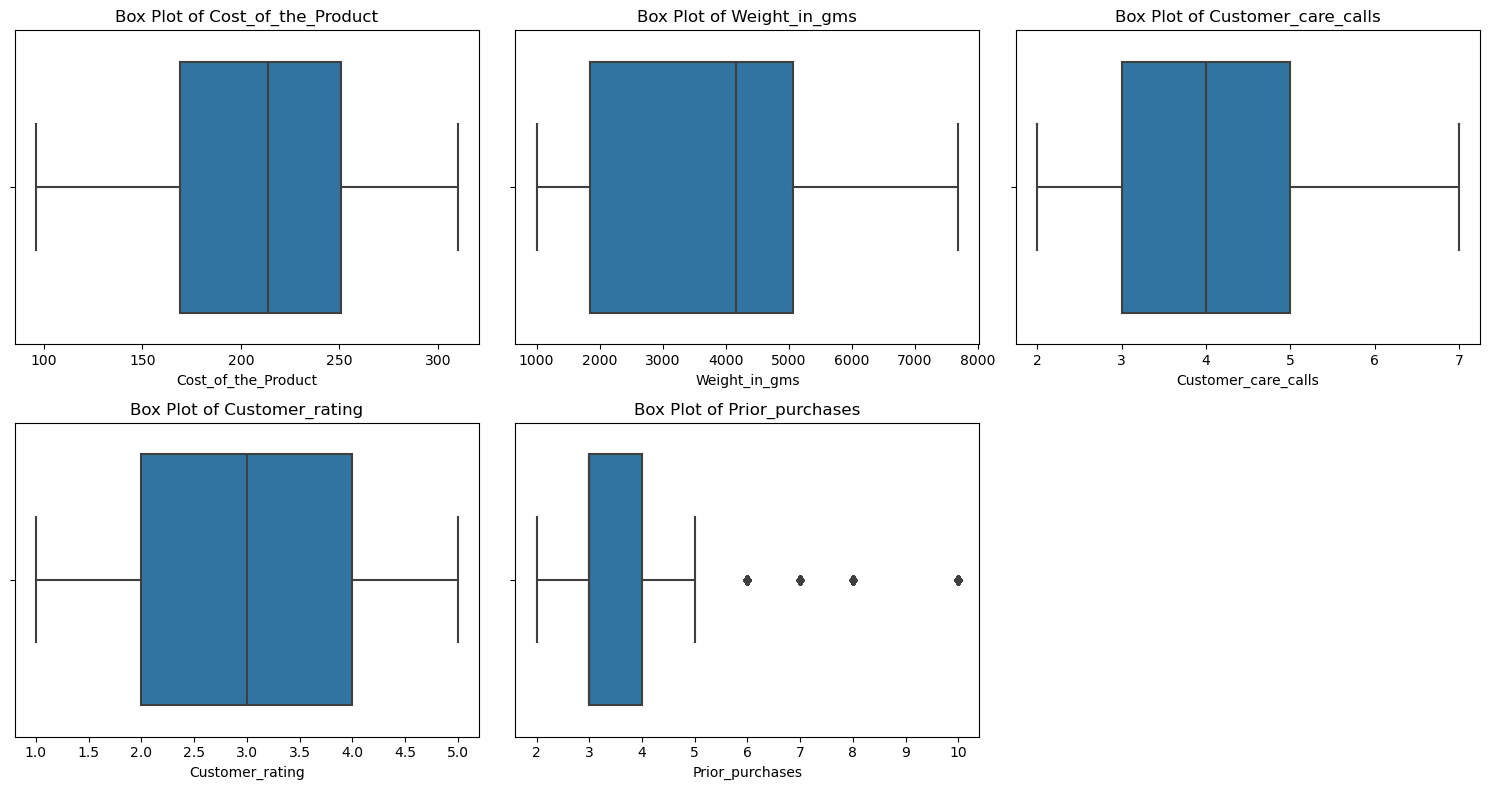

In [6]:
# Visualizing the distribution of numerical columns and identify outliers.

numerical_cols = ['Cost_of_the_Product', 'Weight_in_gms', 'Customer_care_calls', 'Customer_rating', 'Prior_purchases']
# Creating a figure with subplots
plt.figure(figsize=(15, 8))

# Creating subplots for each numerical column
for i, col in enumerate(numerical_cols, 1): 
    plt.subplot(2, 3, i) 
    sns.boxplot(x=data[col]) 
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()



# Impression:
# # Customer_care_calls: 
# # # Expected Outcome: 
#The box plot shows that most customers make a moderate number of customer care calls
# # (e.g., around 3 to 5 calls, based on the sample).


# Customer_rating:
# Expected Outcome:
#The ratings seem to range from 2 to 4.The boxplot shows that most ratings are concentrated around a middle value, with fewer ratings at the extremes.


# Cost_of_the_Product:
# Expected Outcome: The cost of the products in our sample ranges from 176 to 250.The box plot shows how tightly clustered these
#values are around the median, with a possible range of costs.


# Prior_purchases
# Expected Outcome: With prior purchases ranging from 2 to 4 in your sample,the box plot shows a narrow box 
#indicating that most customers have made a similar number of purchases.

# Outliers: Customers with significantly fewer or more purchases appear as outliers.

# Weight_in_gms# Expected Outcome: The weights range from 1,177 to 5,274 grams.
# The box plot shows a wide distribution of weights, especially if the products vary significantly in size.

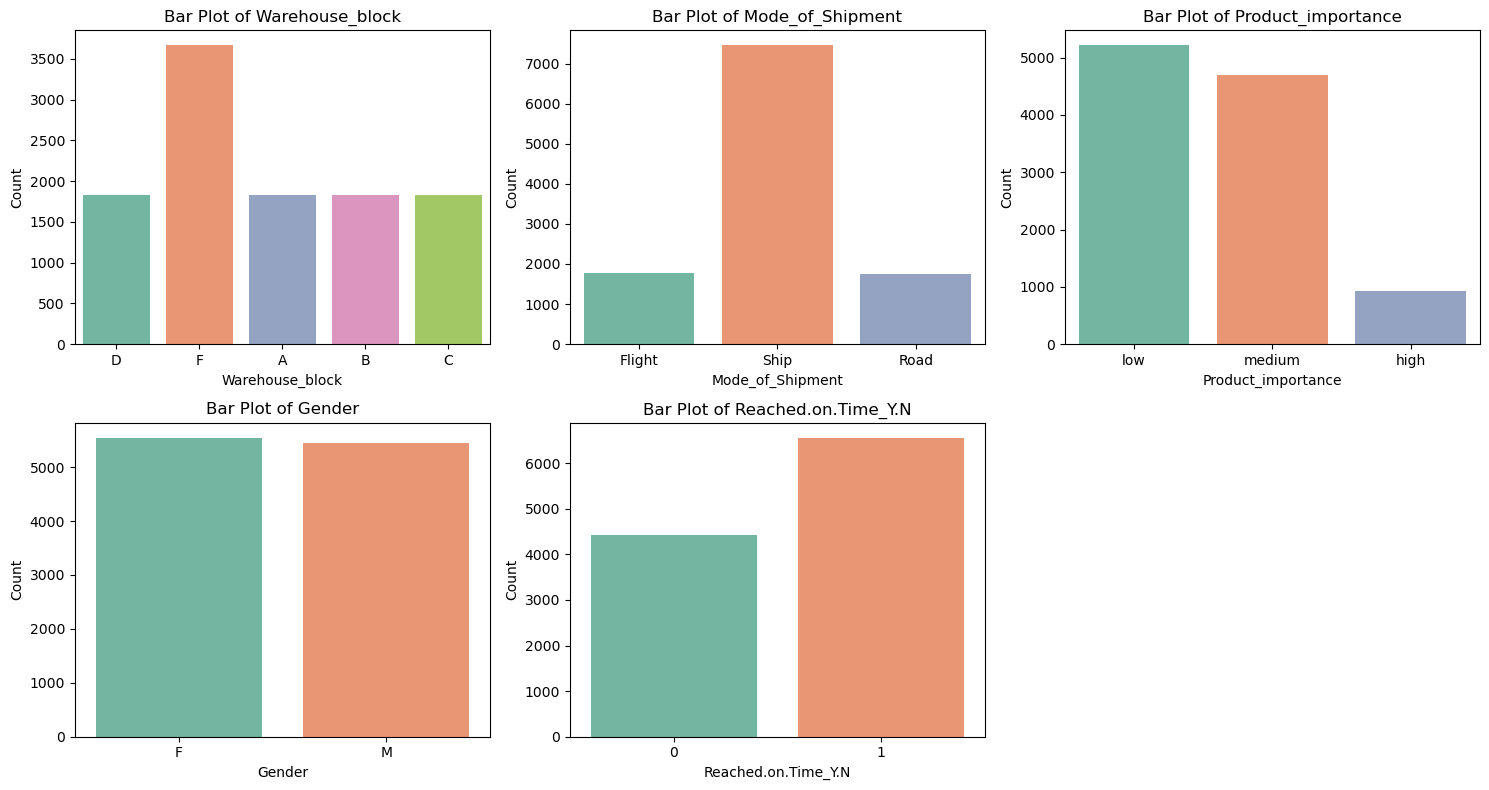

In [10]:
# Using bar plots to understand the distribution of categorical columns and checking for class imbalance in the target variable.

categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N']

plt.figure(figsize=(15, 8))

# Create subplots for each categorical column
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i) 
    sns.countplot(data=data, x=col, palette='Set2')
    plt.title(f'Bar Plot of {col}') 
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [11]:
# Inspecting the dataset for missing values.

missing_values = data.isnull().sum()
print(missing_values)
                         

Warehouse_block          0
Mode_of_Shipment         0
Customer_care_calls      0
Customer_rating          0
Cost_of_the_Product     98
Prior_purchases          0
Product_importance     154
Gender                   0
Discount_offered         0
Weight_in_gms          139
Reached.on.Time_Y.N      0
dtype: int64


In [12]:
# Performing data implant for missing values of Categorical and Numerical data and then re-verifying missing values.

# # categorical data implant
data['Product_importance'] = data['Product_importance'].fillna(data['Product_importance'].mode()[0])

## numerical data implant:# Since the data is normally distributed and has few missing values, we will use mean for both the columns.
data['Cost_of_the_Product'] =data['Cost_of_the_Product'].fillna(data['Cost_of_the_Product'].mean())
data['Weight_in_gms'] = data['Weight_in_gms'].fillna(data['Weight_in_gms'].mean())

# Post imputing the data, we again check to verify the data imputation.
missing_values = data.isnull().sum()
print(missing_values)

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


In [13]:
# Using Label Encoder for the conversion as it converts categorical data into numerical data by assigning a unique integer to each category.

encoder = LabelEncoder()
categorical_cols = ['Product_importance', 'Warehouse_block', 'Mode_of_Shipment', 'Gender']

for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col])

print(data.head())

   Warehouse_block  Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0                3                 0                    4                2   
1                4                 0                    4                5   
2                0                 0                    2                2   
3                1                 0                    3                3   
4                2                 0                    2                2   

   Cost_of_the_Product  Prior_purchases  Product_importance  Gender  \
0                177.0                3                   1       0   
1                216.0                2                   1       1   
2                183.0                4                   1       1   
3                176.0                4                   2       1   
4                184.0                3                   2       0   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44         1233.0            

In [14]:
# Defining features and target variable.

# Features (X) are all columns except the target variable Reached.on.Time_Y.N.
# The target variable (y) is the column that indicates whether the shipment arrived on time.

X = data.drop(columns = ['Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

In [15]:
# Splitting the data

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Initializing the XGBoost model with a specified evaluation metric.

# logarithmic loss" or "log loss," evaluation metric is used for classification problems

model = xgb.XGBClassifier(eval_metric='logloss')

In [17]:
# Taking a dictionary parameter grid allows us to systematically explore different combinations of 
#these hyperparameters to find the set that gives the best performance on our validated data.

param_grid = { 
    'n_estimators': [50, 100], 
    'max_depth': [3, 6],
    'learning_rate': [0.1],
    'min_child_weight': [1]
}

In [18]:
# Using RandomizedSearchCV for faster hyperparameter tuning
# RandomizedSearchCV samples a fixed number of parameter settings from the specified param_grid

randomized_search = RandomizedSearchCV(estimator=model, 
param_distributions=param_grid,n_iter=4, cv=3,scoring='accuracy', n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)
print(f'Best parameters: {randomized_search.best_params_}')


Best parameters: {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}


In [19]:
# Using the best model for predictions

best_model = randomized_search.best_estimator_
y_pred = best_model.predict(X_test)

In [20]:
# Calculating evaluation metrics.

# Assuming '1' indicates 'on time', Printing evaluation results

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print()

# Printing the Recall value
print(f'Recall: {recall:.2f}') 
print()

# Printing the Consusion Matrix
print('Confusion Matrix:')
print(conf_matrix)
print()

# Printing the Classification Report
print('Classification Report:')
print(class_report)

Accuracy: 0.69

Recall: 0.52

Confusion Matrix:
[[836  59]
 [628 677]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       895
           1       0.92      0.52      0.66      1305

    accuracy                           0.69      2200
   macro avg       0.75      0.73      0.69      2200
weighted avg       0.78      0.69      0.68      2200



Feature Importance:
               Feature  Importance
8     Discount_offered    0.739549
5      Prior_purchases    0.144341
9        Weight_in_gms    0.046856
4  Cost_of_the_Product    0.034832
2  Customer_care_calls    0.013551
3      Customer_rating    0.008625
6   Product_importance    0.007349
0      Warehouse_block    0.004897
1     Mode_of_Shipment    0.000000
7               Gender    0.000000



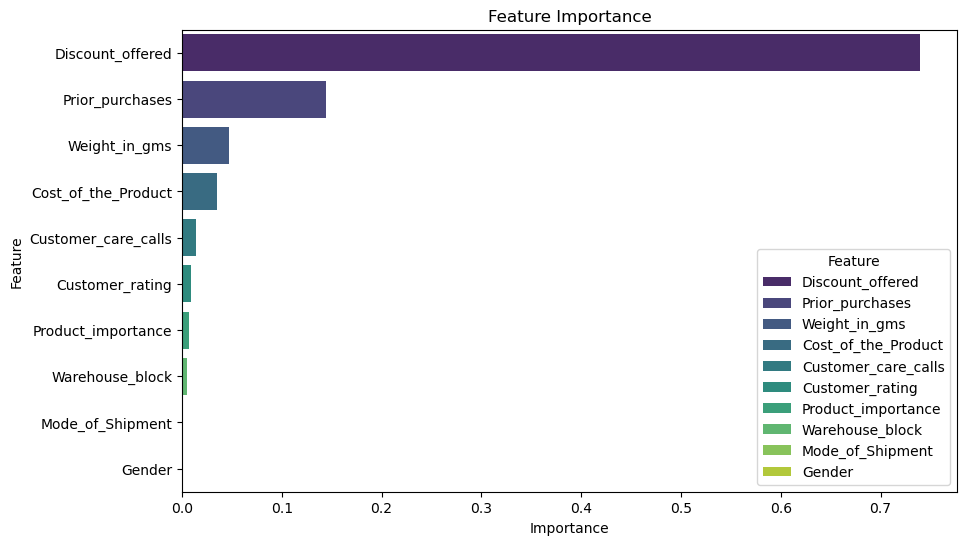

In [21]:
# Checking the Feature Importance which shows which features were used to train the model.

importance = best_model.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print('Feature Importance:')
print(feature_importance)
print()

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance',y='Feature', palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Impressions:# High Importance: Discount_offered and Prior_purchases are critical in predicting shipment timeliness.
# High discounts might be linked to delays, and frequent customers may have different delivery profiles.
# Moderate Importance: Weight_in_gms and Cost_of_the_Product affect delivery times.
# Heavier or more expensive items may face logistical challenges.
# Low Importance: Customer_care_calls, Customer_rating, and Product_importance have minimal impact on predicting delays.
# Negligible Importance: Warehouse_block, Mode_of_Shipment, and
# Gender do not significantly affect on-time performance and may not be influential for this prediction.
